# 

<div class="usecase-title">Air Quality Prediction</div>

<div class="usecase-authors"><b>Authored by: </b> Tharusha Cao</div>

<div class="usecase-duration"><b>Duration:</b> {90} mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, Machine Learning</div>
</div>

<div class="usecase-section-header">Scenario</div>

Air pollution is one of the hot issues that attracted widespread attention from urban and society management. Air quality prediction is to issue an alarm when severe pollution occurs, or pollution concentration exceeds a specific limit, contributing to the measure-taking of relevant departments this is also may be due to development activity, guiding urban socio-economic activities to promote sustainable urban development.

<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:
- python
- Machine Learning
- Deep Learning
- Data Analysis and visualization skills

<div class="usecase-section-header">{Heading for introduction or background relating to problem}</div>

{Write your introduction here. Keep it concise. We're not after "War and Peace" but enough background information to inform the reader on the rationale for solving this problem or background non-technical information that helps explain the approach. You may also wish to give information on the datasets, particularly how to source those not being imported from the client's open data portal.}



import requests
import pandas as pd

# Function that extracts the data from the JSON 
def get_data(base, data_url, offset = 0):
    
    filters = f'records?limit={100}&offset={offset}&timezone=UTC'
    url = f'{base}{data_url}/{filters}'
    result = requests.get(url)
    # if you need to extract more than 9900 records, enter the api key like below
    #result = requests.get(url + f'&apikey={API_KEY}')
    result_json = result.json()
    max_results = result_json['total_count']
    links = result_json['links']
    records = result_json['records']
    records_df = pd.json_normalize(records)
    
    # fix columns names
    records_df.drop(columns=['links'],inplace=True)
    column_names = records_df.columns.values.tolist()
    
    column_names = [i.split('.')[-1] for i in column_names]
    records_df.columns = column_names
    
    next_url = None
    
    # get next url
    if records_df.shape[0] != max_results:
        for l in links:
            if l['rel']=='next':
                next_url = l['href']
                
    return [records_df, next_url, column_names]

# Code

Note the "Discussion" sections are displayed under relevant code outputs.

### Fetching Data ###

In [145]:
###################################################################
# Libraries used:
###################################################################
import numpy as np
import pandas as pd
import seaborn as sns
import folium
import matplotlib.pyplot as plt
import requests
import math
from io import StringIO
from geopy.distance import geodesic
from folium.plugins import MarkerCluster
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from haversine import haversine

In [99]:
f = open("API.txt","r")
api_key = f.read()

In [100]:
#Convert to Function 

def API_Unlimited(datasetname,apikey): # pass in dataset name and api key
    dataset_id = datasetname

    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    apikey = api_key
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC',
        'api_key': apikey
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        datasetname = pd.read_csv(StringIO(url_content), delimiter=';')
        print(datasetname.sample(10, random_state=999)) # Test
        return datasetname 
    else:
        return (print(f'Request failed with status code {response.status_code}'))


"""
Get unlimited data from the API Function 

Parameters:
datasetname (string): dataset name as from city of melbourn 
apikey (string): the current api Key ( this should be gotton via the below if api stored in current workspace / google drive ( refer to Te API)

f = open("API.txt","r")
api_key = f.read()

Returns:
Csv : Returns the csv dataset of the dataset name 
"""


'\nGet unlimited data from the API Function \n\nParameters:\ndatasetname (string): dataset name as from city of melbourn \napikey (string): the current api Key ( this should be gotton via the below if api stored in current workspace / google drive ( refer to Te API)\n\nf = open("API.txt","r")\napi_key = f.read()\n\nReturns:\nCsv : Returns the csv dataset of the dataset name \n'

In [101]:
dataset_id_1 = 'argyle-square-air-quality'
dataset_id_2 = 'development-activity-monitor'
AirQuality_df = API_Unlimited(dataset_id_1,api_key)
ActivityMonitor_df = API_Unlimited(dataset_id_2,api_key)


                             time    dev_id           sensor_name  \
122443  2022-12-03T15:51:38+00:00  ems-ec8a  Air Quality Sensor 2   
127382  2022-12-28T06:48:05+00:00  ems-ec8a  Air Quality Sensor 2   
39281   2020-09-05T03:07:55+00:00  ems-ce10  Air Quality Sensor 1   
125189  2023-01-30T13:58:37+00:00  ems-ec8a  Air Quality Sensor 2   
54591   2022-04-12T04:19:39+00:00  ems-ec8a  Air Quality Sensor 2   
128989  2023-01-23T07:14:52+00:00  ems-ec8a  Air Quality Sensor 2   
109367  2021-02-25T20:47:22+00:00  ems-ec8a  Air Quality Sensor 2   
132986  2023-04-08T08:33:59+00:00  ems-ec8a  Air Quality Sensor 2   
62093   2020-12-08T07:52:16+00:00  ems-ce10  Air Quality Sensor 1   
39623   2020-09-07T04:30:36+00:00  ems-ec8a  Air Quality Sensor 2   

                       lat_long  averagespl  carbonmonoxide  humidity  ibatt  \
122443  -37.802772, 144.9655513        54.0         -4857.0      80.0   89.0   
127382  -37.802772, 144.9655513        55.0         -5793.0      81.0  164.0   


In [102]:
num_records = len(AirQuality_df)
print(f'The dataset 1  contains {num_records} records.')
num_records2 = len(ActivityMonitor_df)
print(f'The dataset 2 contains {num_records2} records.')

The dataset 1  contains 140701 records.
The dataset 2 contains 1430 records.


In [103]:
pd.set_option('display.max_columns', None)
AirQuality_df.head()

,time,dev_id,sensor_name,lat_long,averagespl,carbonmonoxide,humidity,ibatt,nitrogendioxide,ozone,particulateserr,particulatesvsn,peakspl,pm1,pm10,pm25,temperature,vbatt,vpanel
0,2022-05-03T21:46:34+00:00,ems-ec8a,Air Quality Sensor 2,"-37.802772, 144.9655513",58.0,-6261.0,77.0,169.0,268.0,137.0,0.0,151.0,64.0,0.0,0.0,0.0,15.1,3.76,16.33
1,2021-05-15T06:04:33+00:00,ems-ec8a,Air Quality Sensor 2,"-37.802772, 144.9655513",56.0,-6261.0,51.0,12.0,258.0,119.0,0.0,151.0,62.0,0.0,0.0,0.0,14.9,4.01,18.33
2,2021-05-15T06:10:49+00:00,ems-ce10,Air Quality Sensor 1,"-37.802772, 144.9655513",70.0,-2887.0,61.0,132.0,123.0,-13.0,0.0,151.0,87.0,0.0,0.0,0.0,13.2,3.90,16.03
3,2021-05-15T07:49:32+00:00,ems-ec8a,Air Quality Sensor 2,"-37.802772, 144.9655513",56.0,-6822.0,59.0,98.0,306.0,147.0,0.0,151.0,60.0,0.0,1.0,1.0,12.7,3.95,0.00
4,2021-05-15T09:19:32+00:00,ems-ec8a,Air Quality Sensor 2,"-37.802772, 144.9655513",57.0,-6822.0,63.0,109.0,306.0,142.0,0.0,151.0,65.0,2.0,5.0,3.0,12.1,3.93,0.00


### Pre-Proccessing Data ###
##### This section will consist of pre-processing the data sets such as removing unnecessary columns, Filling missing values , Normalization, Encoding and more to help make the data usefull for machine learning and deep learning 

In [104]:
# Removing Uneccerrary columns which wont be any use for data analysis
#From the Air Quality we will be using carbonMonoxide as the Target Feature 
Droping_Features_AirQuality = ['vpanel','vbatt','pm25','pm10','pm1','peakspl','ibatt','averagespl','sensor_name','dev_id']
AirQuality_df = AirQuality_df.drop(columns=Droping_Features_AirQuality)

In [105]:
AirQuality_df.head()

,time,lat_long,carbonmonoxide,humidity,nitrogendioxide,ozone,particulateserr,particulatesvsn,temperature
0,2022-05-03T21:46:34+00:00,"-37.802772, 144.9655513",-6261.0,77.0,268.0,137.0,0.0,151.0,15.1
1,2021-05-15T06:04:33+00:00,"-37.802772, 144.9655513",-6261.0,51.0,258.0,119.0,0.0,151.0,14.9
2,2021-05-15T06:10:49+00:00,"-37.802772, 144.9655513",-2887.0,61.0,123.0,-13.0,0.0,151.0,13.2
3,2021-05-15T07:49:32+00:00,"-37.802772, 144.9655513",-6822.0,59.0,306.0,147.0,0.0,151.0,12.7
4,2021-05-15T09:19:32+00:00,"-37.802772, 144.9655513",-6822.0,63.0,306.0,142.0,0.0,151.0,12.1


#### In this first part we will be trying to predict future AirQuality in Argyle Square, The features used :


##### 1. date_measure - Important component as we need to recognize the change in the pattern
##### 2. Lat Long - Currently only needed for part 2
##### 3. carbonMonoxide - This is the Target for this part, we need to find the carbonMonoxide value for future Dates
##### 4. humidity - Training with corelation
##### 5. nitrogenDioxide - Training with corelation
##### 6. ozone - Training with corelation
##### 7. temperature - Training with corelation
##### 8. particulatesErr - Will be used in Part 2
##### 9. particulatesVsn - Will be used in Part 2

In [106]:
#Checking for empty data 
missing_values = AirQuality_df.isnull().sum()
print("--------------------------Current Missing Values --------------------------")
print(missing_values)


#Lets see propotion
missing_proportion = (missing_values / len(AirQuality_df))*100
print("--------------------------Current Missing Values Propotion --------------------------")
print(missing_proportion)

#Function to call 
def FindMissingVal(df):
  #now lets have a array to store the feature with number of NAN values
  MissingFeaturenValues = []
  #now we check each column
  for column in df.columns:
    missingVals = np.sum(df[column].isnull()) # sum the number of NAN values into variable
    MissingFeaturenValues.append({'Feature':column ,'Number of Missing Values':missingVals}) #the array consist of dictionary with feature and its missing values
  return MissingFeaturenValues


--------------------------Current Missing Values --------------------------
time                  0
lat_long              0
carbonmonoxide     9802
humidity           9802
nitrogendioxide    9802
ozone              9802
particulateserr    9802
particulatesvsn    9802
temperature        9802
dtype: int64
--------------------------Current Missing Values Propotion --------------------------
time               0.000000
lat_long           0.000000
carbonmonoxide     6.966546
humidity           6.966546
nitrogendioxide    6.966546
ozone              6.966546
particulateserr    6.966546
particulatesvsn    6.966546
temperature        6.966546
dtype: float64


##### We can see that there are around 9765 missing values for the Above and We can see that the proportion is 6.993583% of 139629 data points in Aquality Data set 
##### I will be filling the missing values with the mean 

In [107]:
AirQuality_df_copy = AirQuality_df.copy()
for item in FindMissingVal(AirQuality_df):
    if item['Number of Missing Values'] != 0 : # get the number of missing values > 0 we will use mean
        name = item['Feature'] # each column
        print(name + " : Has been replaced with its mean")
        AirQuality_df_copy[name].fillna(value=AirQuality_df[name].mean(), inplace=True) 

carbonmonoxide : Has been replaced with its mean
humidity : Has been replaced with its mean
nitrogendioxide : Has been replaced with its mean
ozone : Has been replaced with its mean
particulateserr : Has been replaced with its mean
particulatesvsn : Has been replaced with its mean
temperature : Has been replaced with its mean


C:\Users\tharu\AppData\Local\Temp\ipykernel_14876\327400964.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  AirQuality_df_copy[name].fillna(value=AirQuality_df[name].mean(), inplace=True)


In [108]:
AirQuality_df_copy.isnull().sum()

time               0
lat_long           0
carbonmonoxide     0
humidity           0
nitrogendioxide    0
ozone              0
particulateserr    0
particulatesvsn    0
temperature        0
dtype: int64

In [109]:
AirQuality_df_copy.head()

,time,lat_long,carbonmonoxide,humidity,nitrogendioxide,ozone,particulateserr,particulatesvsn,temperature
0,2022-05-03T21:46:34+00:00,"-37.802772, 144.9655513",-6261.0,77.0,268.0,137.0,0.0,151.0,15.1
1,2021-05-15T06:04:33+00:00,"-37.802772, 144.9655513",-6261.0,51.0,258.0,119.0,0.0,151.0,14.9
2,2021-05-15T06:10:49+00:00,"-37.802772, 144.9655513",-2887.0,61.0,123.0,-13.0,0.0,151.0,13.2
3,2021-05-15T07:49:32+00:00,"-37.802772, 144.9655513",-6822.0,59.0,306.0,147.0,0.0,151.0,12.7
4,2021-05-15T09:19:32+00:00,"-37.802772, 144.9655513",-6822.0,63.0,306.0,142.0,0.0,151.0,12.1


#### Date Time column needs to be standardized and Lat / Long also needs to be split (Not sure i need right now , i probably will.


In [110]:
# Convert 'date_measure' to datetime remove any incontencies 
AirQuality_df_copy['time'] = pd.to_datetime(AirQuality_df_copy['time'], utc=True)


# Split 'Lat/Long' into two separate columns and convert to float
AirQuality_df_copy[['latitude_air', 'longitude_air']] = AirQuality_df_copy['lat_long'].str.split(', ', expand=True).astype(float)
# Drop the original 'Lat Long' column
AirQuality_df_copy = AirQuality_df_copy.drop(columns=['lat_long'])

AirQuality_df_copy.head()

,time,carbonmonoxide,humidity,nitrogendioxide,ozone,particulateserr,particulatesvsn,temperature,latitude_air,longitude_air
0,2022-05-03 21:46:34+00:00,-6261.0,77.0,268.0,137.0,0.0,151.0,15.1,-37.802772,144.965551
1,2021-05-15 06:04:33+00:00,-6261.0,51.0,258.0,119.0,0.0,151.0,14.9,-37.802772,144.965551
2,2021-05-15 06:10:49+00:00,-2887.0,61.0,123.0,-13.0,0.0,151.0,13.2,-37.802772,144.965551
3,2021-05-15 07:49:32+00:00,-6822.0,59.0,306.0,147.0,0.0,151.0,12.7,-37.802772,144.965551
4,2021-05-15 09:19:32+00:00,-6822.0,63.0,306.0,142.0,0.0,151.0,12.1,-37.802772,144.965551


In [111]:
# Lets add normalization - Since the data has a large gap for each feature normalization would help
#Using Standard Scaling 
#We dont need norms for date_measure,latitude,longitude
AirQuality_df_copy_Normalized = AirQuality_df_copy.copy()
data_float_columns =['carbonmonoxide','humidity','nitrogendioxide','ozone','particulateserr','particulatesvsn','temperature']

scaler = StandardScaler()
AirQuality_df_copy_Normalized[data_float_columns] = scaler.fit_transform(AirQuality_df_copy[data_float_columns])

AirQuality_df_copy_Normalized.head(), AirQuality_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140701 entries, 0 to 140700
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   time             140701 non-null  datetime64[ns, UTC]
 1   carbonmonoxide   140701 non-null  float64            
 2   humidity         140701 non-null  float64            
 3   nitrogendioxide  140701 non-null  float64            
 4   ozone            140701 non-null  float64            
 5   particulateserr  140701 non-null  float64            
 6   particulatesvsn  140701 non-null  float64            
 7   temperature      140701 non-null  float64            
 8   latitude_air     140701 non-null  float64            
 9   longitude_air    140701 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(9)
memory usage: 10.7 MB


(                       time  carbonmonoxide  humidity  nitrogendioxide  \
 0 2022-05-03 21:46:34+00:00       -0.807515  0.325455         0.595440   
 1 2021-05-15 06:04:33+00:00       -0.807515 -1.480662         0.499412   
 2 2021-05-15 06:10:49+00:00        0.852083 -0.786001        -0.796955   
 3 2021-05-15 07:49:32+00:00       -1.083459 -0.924933         0.960343   
 4 2021-05-15 09:19:32+00:00       -1.083459 -0.647069         0.960343   
 
       ozone  particulateserr  particulatesvsn  temperature  latitude_air  \
 0  0.810778        -0.002866         0.182401    -0.310225    -37.802772   
 1  0.564059        -0.002866         0.182401    -0.347404    -37.802772   
 2 -1.245212        -0.002866         0.182401    -0.663426    -37.802772   
 3  0.947844        -0.002866         0.182401    -0.756373    -37.802772   
 4  0.879311        -0.002866         0.182401    -0.867910    -37.802772   
 
    longitude_air  
 0     144.965551  
 1     144.965551  
 2     144.965551  
 3  

-------------- View BEFORE SCALING-----------------


<Figure size 1000x1000 with 0 Axes>

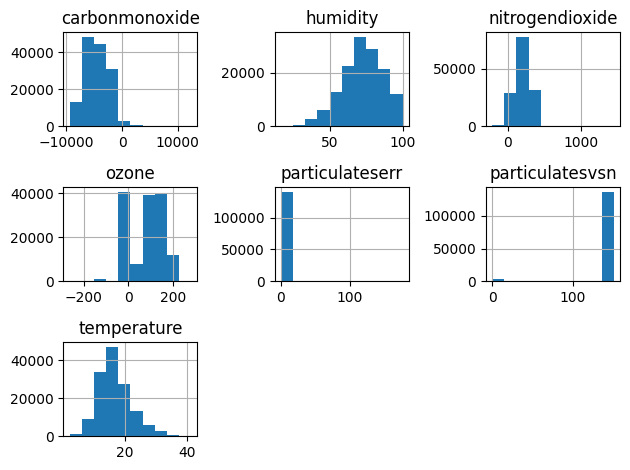

-------------- View AFTER SCALING-----------------


<Figure size 1000x1000 with 0 Axes>

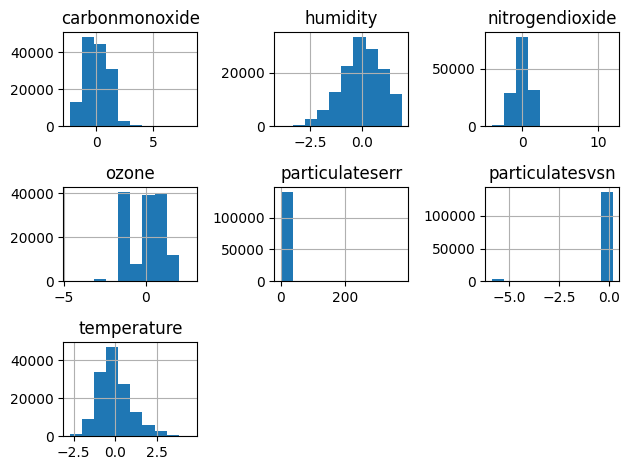

In [112]:
#Lets see the scaling before and after
print("-------------- View BEFORE SCALING-----------------")
plt.figure(figsize=(10, 10))
AirQuality_df_copy[data_float_columns].hist()
plt.tight_layout()
plt.show()


print("-------------- View AFTER SCALING-----------------")
plt.figure(figsize=(10, 10))
AirQuality_df_copy_Normalized[data_float_columns].hist()
plt.tight_layout()
plt.show()

### Now we check the Development Activity Monitor DataSet

In [113]:
ActivityMonitor_df.head()

,data_format,development_key,status,year_completed,clue_small_area,clue_block,street_address,property_id,property_id_2,property_id_3,property_id_4,property_id_5,floors_above,resi_dwellings,studio_dwe,one_bdrm_dwe,two_bdrm_dwe,three_bdrm_dwe,student_apartments,student_beds,student_accommodation_units,institutional_accom_beds,hotel_rooms,serviced_apartments,hotels_serviced_apartments,hostel_beds,childcare_places,office_flr,retail_flr,industrial_flr,storage_flr,education_flr,hospital_flr,recreation_flr,publicdispaly_flr,community_flr,car_spaces,bike_spaces,town_planning_application,longitude,latitude,geopoint
0,Pre May 16,X000288,COMPLETED,2011.0,Melbourne (CBD),104,150-154 A'Beckett Street MELBOURNE VIC 3000,100163,NaN,NaN,NaN,NaN,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,583,0,0,0,0,0,0,0,144.958971,-37.809597,"-37.80959665, 144.9589709"
1,Pre May 16,X000449,COMPLETED,2009.0,North Melbourne,315,North Melbourne Recreation Reserve 204-206 Ard...,100514,NaN,NaN,NaN,NaN,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1768,101,0,0,0,0,2494,0,0,0,0,0,144.941433,-37.798926,"-37.79892607, 144.9414326"
2,Pre May 16,X000395,COMPLETED,2005.0,Carlton,257,24-30 Barkly Place CARLTON VIC 3053,100732,NaN,NaN,NaN,NaN,6,0,0,0,0,0,83,0,83,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144.961448,-37.803003,"-37.803003, 144.9614476"
3,Pre May 16,X000279,COMPLETED,2014.0,West Melbourne (Residential),101,49-53 Batman Street WEST MELBOURNE VIC 3003,100850,NaN,NaN,NaN,NaN,16,140,0,114,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,0,144.951554,-37.811134,"-37.81113438, 144.9515544"
4,Pre May 16,X000231,COMPLETED,2003.0,Melbourne (CBD),87,11-21 Bennetts Lane MELBOURNE VIC 3000,101021,NaN,NaN,NaN,NaN,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,580,320,0,0,0,0,0,0,0,0,0,0,144.967682,-37.809166,"-37.80916563, 144.9676825"


In [114]:
column_names = list(ActivityMonitor_df.columns.values)
column_names

['data_format',
 'development_key',
 'status',
 'year_completed',
 'clue_small_area',
 'clue_block',
 'street_address',
 'property_id',
 'property_id_2',
 'property_id_3',
 'property_id_4',
 'property_id_5',
 'floors_above',
 'resi_dwellings',
 'studio_dwe',
 'one_bdrm_dwe',
 'two_bdrm_dwe',
 'three_bdrm_dwe',
 'student_apartments',
 'student_beds',
 'student_accommodation_units',
 'institutional_accom_beds',
 'hotel_rooms',
 'serviced_apartments',
 'hotels_serviced_apartments',
 'hostel_beds',
 'childcare_places',
 'office_flr',
 'retail_flr',
 'industrial_flr',
 'storage_flr',
 'education_flr',
 'hospital_flr',
 'recreation_flr',
 'publicdispaly_flr',
 'community_flr',
 'car_spaces',
 'bike_spaces',
 'town_planning_application',
 'longitude',
 'latitude',
 'geopoint']

In [115]:
# Removing Uneccerrary columns which wont be any use for data analysis
#From the Air Quality we will be using carbonMonoxide as the Target Feature 

# my main focus by using this data is to see if a building built in the radius od the air pollution sensor location effected the air pollution and see the '
#relatioonship , hence we can drop all the features expect the geolocation, date (year) , and status 

#for we can also see which types of buildings contribute to air pollution more later in , for now lets drop them and copy to new DF
Droping_Features_ActivityMonitor = ['data_format','development_key','clue_small_area','clue_block','street_address','property_id',
 'property_id_2','property_id_3','property_id_4','property_id_5','floors_above','resi_dwellings','studio_dwe','one_bdrm_dwe','two_bdrm_dwe','three_bdrm_dwe','student_apartments',
 'student_beds','student_accommodation_units','institutional_accom_beds','hotel_rooms','serviced_apartments','hotels_serviced_apartments','hostel_beds','childcare_places','office_flr',
 'retail_flr','industrial_flr','storage_flr','education_flr','hospital_flr','recreation_flr','publicdispaly_flr','community_flr','car_spaces',
 'bike_spaces','town_planning_application','geopoint']

ActivityMonitor_df_Dropped = ActivityMonitor_df.copy()

ActivityMonitor_df_Dropped = ActivityMonitor_df_Dropped.drop(columns=Droping_Features_ActivityMonitor)

In [116]:
ActivityMonitor_df_Dropped.head()

,status,year_completed,longitude,latitude
0,COMPLETED,2011.0,144.958971,-37.809597
1,COMPLETED,2009.0,144.941433,-37.798926
2,COMPLETED,2005.0,144.961448,-37.803003
3,COMPLETED,2014.0,144.951554,-37.811134
4,COMPLETED,2003.0,144.967682,-37.809166


In [117]:
ActivityMonitor_df_Dropped.shape
#1430 rows of data 

(1430, 4)

In [118]:
#calling finding missing val function 
FindMissingVal(ActivityMonitor_df_Dropped)

[{'Feature': 'status', 'Number of Missing Values': 0},
 {'Feature': 'year_completed', 'Number of Missing Values': 394},
 {'Feature': 'longitude', 'Number of Missing Values': 0},
 {'Feature': 'latitude', 'Number of Missing Values': 0}]

In [119]:
#checking propotion 
missing_values = ActivityMonitor_df_Dropped.isnull().sum()
missing_proportion = (missing_values / len(ActivityMonitor_df_Dropped))*100
print("--------------------------Current Missing Values Propotion --------------------------")
print(missing_proportion)

print("missing propotion is not that bad at 27% , we can try replacing the missing values with its mode ")

#replacing with mode :

ActivityMonitor_df_FillNA = ActivityMonitor_df_Dropped.copy()
for item in FindMissingVal(ActivityMonitor_df_Dropped):
    if item['Number of Missing Values'] != 0 : # get the number of missing values > 0 we will use mean
        name = item['Feature'] # each column
        print(name + " : Has been replaced with its mode")
        ActivityMonitor_df_FillNA[name].fillna(value=ActivityMonitor_df_Dropped[name].mode()[0], inplace=True)  # mode fill 

--------------------------Current Missing Values Propotion --------------------------
status             0.000000
year_completed    27.552448
longitude          0.000000
latitude           0.000000
dtype: float64
missing propotion is not that bad at 27% , we can try replacing the missing values with its mode 
year_completed : Has been replaced with its mode


C:\Users\tharu\AppData\Local\Temp\ipykernel_14876\270070995.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ActivityMonitor_df_FillNA[name].fillna(value=ActivityMonitor_df_Dropped[name].mode()[0], inplace=True)  # mode fill


In [120]:
ActivityMonitor_df_FillNA.head()

,status,year_completed,longitude,latitude
0,COMPLETED,2011.0,144.958971,-37.809597
1,COMPLETED,2009.0,144.941433,-37.798926
2,COMPLETED,2005.0,144.961448,-37.803003
3,COMPLETED,2014.0,144.951554,-37.811134
4,COMPLETED,2003.0,144.967682,-37.809166


In [121]:
FindMissingVal(ActivityMonitor_df_FillNA)

[{'Feature': 'status', 'Number of Missing Values': 0},
 {'Feature': 'year_completed', 'Number of Missing Values': 0},
 {'Feature': 'longitude', 'Number of Missing Values': 0},
 {'Feature': 'latitude', 'Number of Missing Values': 0}]

In [122]:
ActivityMonitor_df_FillNA.isnull().sum()

status            0
year_completed    0
longitude         0
latitude          0
dtype: int64

In [123]:
#DOES NOT NEED TO BE STANDARDIZED 
""" Probably will be needing catageroical encoding """

' Probably will be needing catageroical encoding '

#### Linear Regression / Visualization
##### To start off I will be using a Baisc model of linear regression to predict future air quality in Argyle Square , later on we will look into other models more on the unsupervised side such as neural networks , classification ( which building development causes most pollution ) 

In [151]:
#make code easier , no need to rerun the top expect the library imports
AirQuality_df_copy_Normalized.to_csv(r"AirQuality_preprocessed.csv", index=False)
ActivityMonitor_df_FillNA.to_csv(r"ActivityMonitor_preprocessed.csv", index=False)

##### Visual of the AirQuality 

In [152]:
df1 = "AirQuality_preprocessed.csv"
df2 ="ActivityMonitor_preprocessed.csv"
Air_df = pd.read_csv(df1)
Activity_df = pd.read_csv(df2)


In [82]:
import folium
from folium.plugins import MarkerCluster

average_latitude = Air_df['latitude_air'].mean()
average_longitude = Air_df['longitude_air'].mean()

# Initialize the map
map = folium.Map(location=[average_latitude, average_longitude], zoom_start=13)

# Iterate through the dataset
for idx, row in Air_df.iterrows():
    # Add a marker
    folium.CircleMarker(
        location=[average_latitude,average_longitude],
        radius=5,
        color=marker_color,
        fill=True,
        fill_color=marker_color,
        fill_opacity=0.6,
        popup=f"Time: {row['time']}\nParticulate Level: {particulate_level}"
    ).add_to(map)

# Save
map.save('air_quality_map.html')


We can see the correlation of each feature below , i will add a heat map

In [126]:
#Finding colreation of data 
features = Air_df.drop(columns=['time', 'latitude_air', 'longitude_air'])
correlation_matrix = features.corr()
correlation_matrix

,carbonmonoxide,humidity,nitrogendioxide,ozone,particulateserr,particulatesvsn,temperature
carbonmonoxide,1.000000,-0.408335,-0.899556,-0.938631,0.002829,0.028755,0.601240
humidity,-0.408335,1.000000,0.399839,0.248101,0.003831,-0.032264,-0.646988
nitrogendioxide,-0.899556,0.399839,1.000000,0.888618,-0.004505,-0.018072,-0.491108
ozone,-0.938631,0.248101,0.888618,1.000000,-0.004087,-0.018212,-0.357668
particulateserr,0.002829,0.003831,-0.004505,-0.004087,1.000000,-0.014745,-0.003107
particulatesvsn,0.028755,-0.032264,-0.018072,-0.018212,-0.014745,1.000000,0.049736
temperature,0.601240,-0.646988,-0.491108,-0.357668,-0.003107,0.049736,1.000000


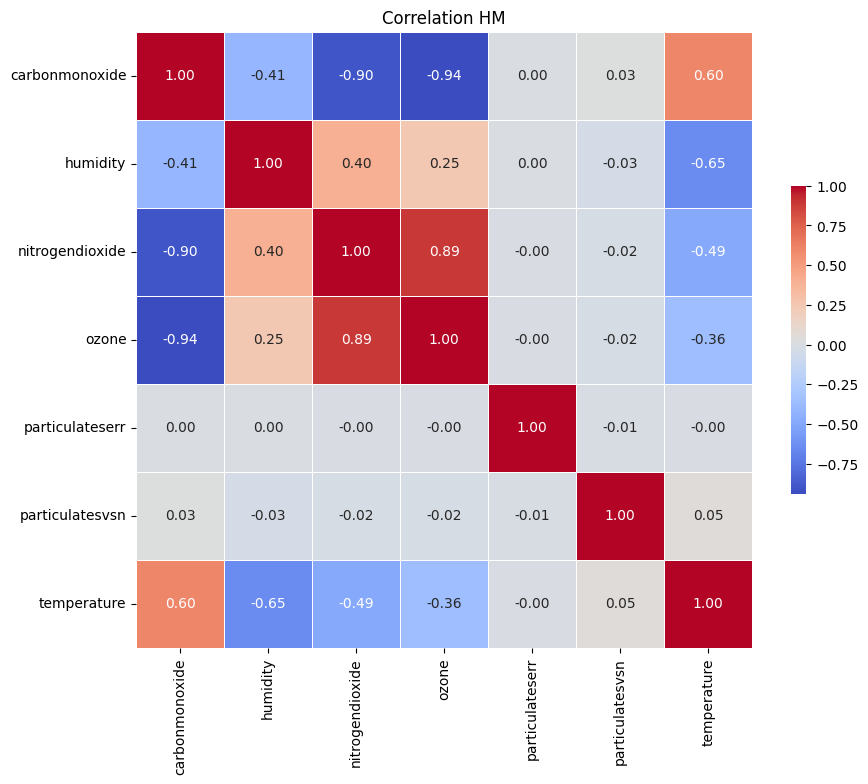

In [127]:

plt.figure(figsize=(10, 8))

#aHeat Map
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, cbar_kws={"shrink": .5}, linewidths=.5)

plt.title('Correlation HM')
plt.show()


### When values are closer to 1 it indicates a positive correlation 
#### Carbon monoxide and temperature 
#### ozone and nitrogen dioxide 
#### Nitrogen dioxide  and humidity 
#### Ozone and humidity 
### When values are closer to 1 it indicates a Negative correlation 
#### Carbon monoxide and ozone 
#### Carbon monoxide and nitrogen dioxide 
#### Temperature  and humidity 
#### Carbon monoxide and humidity 

In [128]:

X = Air_df[['temperature', 'nitrogendioxide', 'ozone']] #features we ill be using to predict the carbon monoxide 
y = Air_df['carbonmonoxide']#our target feature
#Splitting data train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #30% test size

#Linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

###########################################PREDICTING###############################################
y_pred = model.predict(X_test)

###########################################EVALUATION###############################################
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.03607669563644315
R-squared: 0.9640272758744125


#### Mean Squared Error (MSE) : 0.03531038122228091 is a good indication that the average of the squares of the errors between the predicted and actual carbon monoxide levels are low hence a better fit for the data
#### R-squared:  shows how well the variability in carbon monoxide levels is. value close to 1 shows a model that closely fits the data.  0.960 :  model does an very good job of showing the variance in carbon monoxide levels based on the features i trained it with.

### In conclusion for this model of linear regression we can see good results where there is very little MSE and good R-squared. hence the LR model will accurately be able to predict future carbon monoxide levels.

In [129]:
#Combine Dataset InnerJoin
#Air_df 
#Activity_df 
Air_df['time'] = pd.to_datetime(Air_df['time'], utc=True)
Air_df['year'] = pd.to_datetime(Air_df['time']).dt.year

#Check year ranges 
unique_years = Activity_df['year_completed'].unique()
sorted_unique_years = np.sort(unique_years)

unique_years_air = Air_df['year'].unique()
sorted_unique_years_air = np.sort(unique_years_air)

print("AIR : ",sorted_unique_years_air)
print("DEV : ",sorted_unique_years)

# Filter
filtered_activity_monitor = Activity_df[Activity_df['year_completed'].isin([2020, 2021, 2022, 2023, 2024])]
filtered_activity_monitor.head(), filtered_activity_monitor.shape

# Merge
combined_dataset = pd.merge(filtered_activity_monitor, Air_df, left_on='year_completed', right_on='year', how='inner')
combined_dataset.drop('year_completed', axis=1, inplace=True)
combined_dataset.head(100), combined_dataset.shape

AIR :  [2020 2021 2022 2023 2024]
DEV :  [2002. 2003. 2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013.
 2014. 2015. 2016. 2017. 2018. 2019. 2020. 2021. 2022. 2023. 2024.]


(       status   longitude   latitude                      time  \
 0   COMPLETED  144.945752 -37.809098 2020-06-09 09:02:38+00:00   
 1   COMPLETED  144.945752 -37.809098 2020-06-09 11:17:37+00:00   
 2   COMPLETED  144.945752 -37.809098 2020-06-09 11:32:37+00:00   
 3   COMPLETED  144.945752 -37.809098 2020-06-09 12:17:37+00:00   
 4   COMPLETED  144.945752 -37.809098 2020-06-09 13:47:36+00:00   
 ..        ...         ...        ...                       ...   
 95  COMPLETED  144.945752 -37.809098 2020-06-10 23:21:59+00:00   
 96  COMPLETED  144.945752 -37.809098 2020-06-10 23:36:59+00:00   
 97  COMPLETED  144.945752 -37.809098 2020-06-11 00:02:22+00:00   
 98  COMPLETED  144.945752 -37.809098 2020-06-11 00:06:59+00:00   
 99  COMPLETED  144.945752 -37.809098 2020-06-11 00:17:22+00:00   
 
     carbonmonoxide  humidity  nitrogendioxide     ozone  particulateserr  \
 0        -0.899497 -0.508137         0.777891  0.810778        -0.002866   
 1        -1.129696 -0.299739         1.

In [130]:
#Checking for empty data 
missing_values = combined_dataset.isnull().sum()
print("--------------------------Current Missing Values --------------------------")
print(missing_values)


#Lets see propotion
missing_proportion = (missing_values / len(combined_dataset))*100
print("--------------------------Current Missing Values Propotion --------------------------")
print(missing_proportion)

--------------------------Current Missing Values --------------------------
status             0
longitude          0
latitude           0
time               0
carbonmonoxide     0
humidity           0
nitrogendioxide    0
ozone              0
particulateserr    0
particulatesvsn    0
temperature        0
latitude_air       0
longitude_air      0
year               0
dtype: int64
--------------------------Current Missing Values Propotion --------------------------
status             0.0
longitude          0.0
latitude           0.0
time               0.0
carbonmonoxide     0.0
humidity           0.0
nitrogendioxide    0.0
ozone              0.0
particulateserr    0.0
particulatesvsn    0.0
temperature        0.0
latitude_air       0.0
longitude_air      0.0
year               0.0
dtype: float64


In [131]:
#Encoding status
status_encoded = pd.get_dummies(combined_dataset['status'], prefix='status')
combined_dataset_encoded = pd.concat([combined_dataset.drop('status', axis=1), status_encoded], axis=1)
print(combined_dataset_encoded.head())

    longitude   latitude                      time  carbonmonoxide  humidity  \
0  144.945752 -37.809098 2020-06-09 09:02:38+00:00       -0.899497 -0.508137   
1  144.945752 -37.809098 2020-06-09 11:17:37+00:00       -1.129696 -0.299739   
2  144.945752 -37.809098 2020-06-09 11:32:37+00:00       -1.129696 -0.230273   
3  144.945752 -37.809098 2020-06-09 12:17:37+00:00       -1.267914 -0.021875   
4  144.945752 -37.809098 2020-06-09 13:47:36+00:00       -1.129696  0.255989   

   nitrogendioxide     ozone  particulateserr  particulatesvsn  temperature  \
0         0.777891  0.810778        -0.002866         0.182401    -0.830731   
1         1.142795  1.071204        -0.002866         0.182401    -1.090985   
2         1.142795  1.071204        -0.002866         0.182401    -1.165343   
3         1.421274  1.126030        -0.002866         0.182401    -1.276880   
4         1.325246  1.194563        -0.002866         0.182401    -1.425596   

   latitude_air  longitude_air  year  status

In [132]:

combined_dataset_encoded.to_csv(r"combined_dataset_encoded.csv", index=False)

In [133]:
combined ='combined_dataset_encoded.csv'
combined_df = pd.read_csv(combined)

#### Visualize the activity dataset

There are alot of points in the dataset hence im only limiting to visualize the ones in 1km radius 

In [170]:
from geopy.distance import distance #using geopy to ge the distance 

center_coord = (-37.802772, 144.965551) # avergae coord of the airquality
radius = 1000
def calculate_distance_geopy(lat1, lon1, lat2, lon2):
    return distance((lat1, lon1), (lat2, lon2)).meters
#ADD to new ds , with filtered data of 1km for visuals 
filtered_data = filtered_activity_monitor.loc[filtered_activity_monitor.apply(lambda row: calculate_distance_geopy(center_coord[0], center_coord[1], row['latitude'], row['longitude']) < radius, axis=1)] 



In [171]:
filtered_map = folium.Map(location=center_coord, zoom_start=15)
#Radius Circle of 1 km 
folium.Circle(
    center_coord,
    radius=radius,
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.2,
    popup='1000-meter Radius'
).add_to(filtered_map)

#add markers with relevant information
for index, activity in filtered_data.iterrows(): #
    folium.Marker(
        location=[activity['latitude'], activity['longitude']],
        popup=f"Year: {activity['year_completed']}, Status: {activity['status']}",
        icon=folium.Icon(color='green', icon='info-sign')
    ).add_to(filtered_map)

filtered_map

